<a href="https://colab.research.google.com/github/proditorIF/Derma_sense_HackAi/blob/main/codes/derma_sense_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **DERMA SENSE**

Diagnóstico preliminar de cáncer de piel con IA

## Instalaciones previas

Iniciamos sesión en Hugging Face para guardar en la nube el modelo preentrenado

In [ ]:
!pip install huggingface-cli

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Instalamos librerías necesarias

In [ ]:
!pip install transformers -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0


In [ ]:
!pip install datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


## Trabajamos DATASET

Hay dos categorías para la clasificación, maligno y benigno.
Separamos el conjunto de datos en test, train y validation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_data_train = "/content/drive/MyDrive/Hackaton/data/train"
path_data_validation = "/content/drive/MyDrive/Hackaton/data/validation"
path_data_test = "/content/drive/MyDrive/Hackaton/data/test"

In [ ]:
label_dic={"malignant":0, "ben":1}

In [ ]:
from datasets import ClassLabel, Dataset, Features, Image, Value, Sequence, DatasetDict
from PIL import Image as PImage, ImageOps
import numpy as np

In [ ]:
Clabels= ClassLabel(num_classes=2, names=["malignant", "ben"])

In [ ]:
import os
import glob

list_images=[]
list_path=[]
list_labels=[]


from fnmatch import fnmatch
pattern = "*.jpg"

# Train Dataset
for path, subdirs, files in os.walk(path_data_train):
    for name in files:
      #if fnmatch(name, pattern):
          abs_path = (os.path.join(path, name))
          # abs_path
          category=abs_path.split("/")[-2]
          # name
          image = PImage.open(abs_path)
          # image = ImageOps.contain(image, (400,400))
          list_images.append(image)
          list_path.append(abs_path)
          list_labels.append(label_dic.get(category))

In [ ]:
dtrain= { "image": list_images, "image_file_path": list_path, "labels":list_labels}
ds_train = Dataset.from_dict(mapping=dtrain, features=Features({"labels": Value(dtype='int8'), 'image_file_path': Value(dtype='string'), 'image': Image()}))
ds_train = ds_train.cast_column("labels", Clabels)
ds_train = ds_train.shuffle(seed=42)
ds_train

Casting the dataset:   0%|          | 0/2041 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'image_file_path', 'labels'],
    num_rows: 2041
})

In [ ]:
# Validation Dataset
list_images=[]
list_path=[]
list_labels=[]
list_cats=[]


# validation Dataset
for path, subdirs, files in os.walk(path_data_validation):
    for name in files:
      if fnmatch(name, pattern):
            abs_path = (os.path.join(path, name))
            # abs_path
            category=abs_path.split("/")[-2]
            # name
            image = PImage.open(abs_path)
            # image = ImageOps.contain(image, (400,400))
            list_images.append(image)
            list_path.append(abs_path)
            list_labels.append(label_dic.get(category))
            list_cats.append(category)



dvalidation= { "image": list_images, "image_file_path": list_path, "labels":list_labels}
ds_validation = Dataset.from_dict(mapping=dvalidation, features=Features({"labels": Value(dtype='int8'), 'image_file_path': Value(dtype='string'), 'image': Image()}))
ds_validation = ds_validation.cast_column("labels", Clabels)
ds_validation

Casting the dataset:   0%|          | 0/596 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'image_file_path', 'labels'],
    num_rows: 596
})

In [ ]:
# test Dataset
list_images=[]
list_path=[]
list_labels=[]
list_cats=[]


# test Dataset
for path, subdirs, files in os.walk(path_data_test):
    for name in files:
      if fnmatch(name, pattern):
            abs_path = (os.path.join(path, name))
            # abs_path
            category=abs_path.split("/")[-2]
            # name
            image = PImage.open(abs_path)
            #iimage = ImageOps.contain(image, (400,400))
            list_images.append(image)
            list_path.append(abs_path)
            list_labels.append(label_dic.get(category))
            list_cats.append(category)



dtest= { "image": list_images, "image_file_path": list_path, "labels":list_labels}
ds_test = Dataset.from_dict(mapping=dtest, features=Features({"labels": Value(dtype='int8'), 'image_file_path': Value(dtype='string'), 'image': Image()}))
ds_test = ds_test.cast_column("labels", Clabels)
ds_test


Casting the dataset:   0%|          | 0/660 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'image_file_path', 'labels'],
    num_rows: 660
})

In [ ]:
ds = DatasetDict({"train": ds_train, "validation": ds_validation, "test": ds_test})

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'image_file_path', 'labels'],
        num_rows: 2041
    })
    validation: Dataset({
        features: ['image', 'image_file_path', 'labels'],
        num_rows: 596
    })
    test: Dataset({
        features: ['image', 'image_file_path', 'labels'],
        num_rows: 660
    })
})

Revisamos un ejemplo del dataset

In [ ]:
ds['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'image_file_path': Value(dtype='string', id=None),
 'labels': ClassLabel(names=['malignant', 'ben'], id=None)}

In [ ]:
ex = ds['train'][5]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'image_file_path': '/content/drive/MyDrive/Hackaton/data/train/ben/246.jpg',
 'labels': 1}

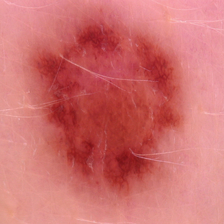

In [ ]:
image = ex['image']
image

In [ ]:
#Labels ver
labels = ds['train'].features['labels']
print(labels)

ClassLabel(names=['malignant', 'ben'], id=None)


Filter:   0%|          | 0/2041 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2041 [00:00<?, ? examples/s]

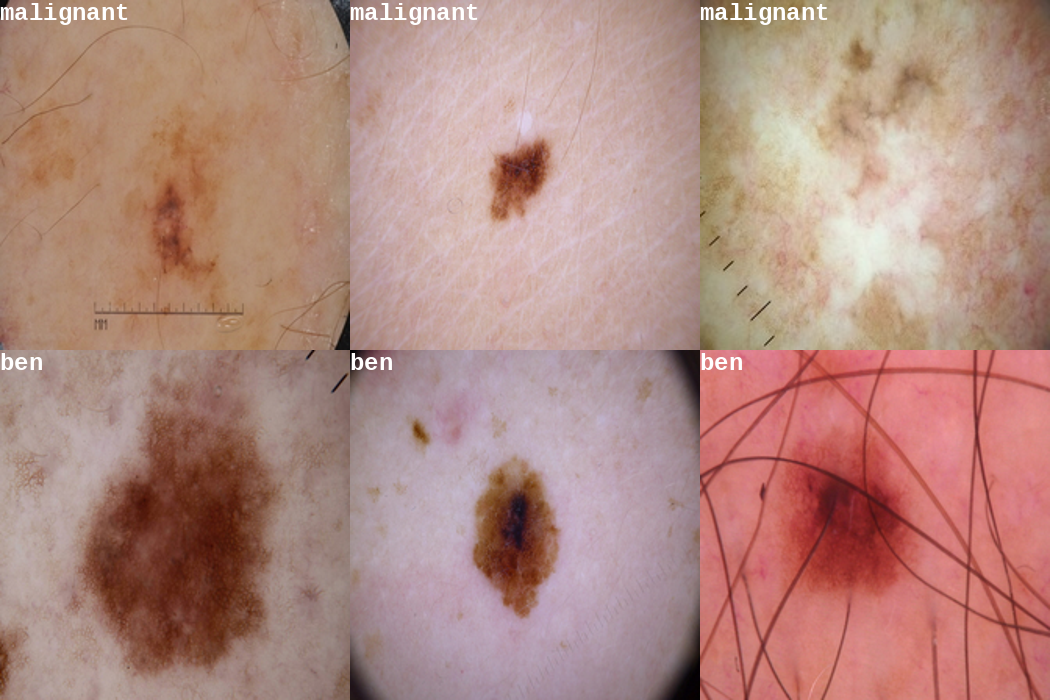

In [ ]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 133), examples_per_class=3)


## Entrenamiento

Importamos el transformer viT

In [ ]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [ ]:
prepared_ds = ds.with_transform(transform)

In [ ]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[ 0.4980,  0.6314,  0.5765,  ...,  0.7333,  0.7333,  0.7569],
          [ 0.5059,  0.6314,  0.5843,  ...,  0.6784,  0.7333,  0.7333],
          [ 0.5451,  0.6627,  0.6235,  ...,  0.7176,  0.7333,  0.7098],
          ...,
          [ 0.5059,  0.6000,  0.5373,  ...,  0.6784,  0.6706,  0.6863],
          [ 0.5059,  0.6078,  0.5922,  ...,  0.6863,  0.6784,  0.6706],
          [ 0.5059,  0.6235,  0.5765,  ...,  0.6863,  0.6627,  0.6627]],

         [[ 0.1608,  0.2000,  0.1922,  ...,  0.3804,  0.3961,  0.3961],
          [ 0.1608,  0.2392,  0.2078,  ...,  0.3569,  0.3961,  0.3961],
          [ 0.1686,  0.2471,  0.2392,  ...,  0.3804,  0.3961,  0.3804],
          ...,
          [ 0.1137,  0.1451,  0.0510,  ...,  0.2706,  0.2863,  0.2941],
          [ 0.1294,  0.1922,  0.1529,  ...,  0.2941,  0.2941,  0.2706],
          [ 0.1137,  0.1922,  0.1765,  ...,  0.3176,  0.2784,  0.2471]],

         [[ 0.1059,  0.1451,  0.0824,  ...,  0.4196,  0.4510,  0.4824],
          [ 0

In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-27-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install accelerate -U

Configuración de parámetros de entrenamiento

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-derma-sense",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=1,
  fp16=False,  # Disable FP16 mixed precision training
  fp16_full_eval=False,  # Disable FP16 half precision evaluation
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=processor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

## Métrica de evaluación

In [ ]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)